In [1]:
import os
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from multiscale_run import config

conf = config.MsrConfig()

In [3]:
paths = [Path("RESULTS")]
# database for gid-based reports
dfs = [{} for i in enumerate(paths)]
# database for vasculature-segmnet-based reports. Currently unused
dfs_bf = [{} for i in enumerate(paths)]
units = [{} for i in enumerate(paths)]

neuron_population_name = conf.multiscale_run.preprocessor.node_sets.neuron_population_name
for ii, path in enumerate(paths):
    for file_path in path.glob("*.h5"):
        if file_path.name not in {"out.h5", "ndam_spikes.h5"}:
            try:
                with h5py.File(file_path, "r") as file:
                    # Get the data and column names
                    data_path = f"/report/{neuron_population_name}/data"
                    column_path = f"/report/{neuron_population_name}/mapping/node_ids"
                    time_path = f"/report/{neuron_population_name}/mapping/time"
                    q = dfs_bf if file_path.name.startswith("bf") else dfs

                    # Load data and column names into Pandas dataframes
                    q[ii][file_path.name] = pd.DataFrame(file[data_path][:])
                    q[ii][file_path.name].columns = file[column_path][:]
                    starting_point, _, time_step = file[time_path]
                    ending_point = starting_point + q[ii][file_path.name].shape[0] * time_step
                    ts = np.arange(starting_point, ending_point, time_step)
                    q[ii][file_path.name]["t"] = ts

                    units[ii][file_path.name] = [
                        file[time_path].attrs["units"],
                        file[data_path].attrs["units"],
                    ]
            except OSError:
                continue
            print(f"loaded file: {file_path}")

loaded file: RESULTS/ndam_ki.h5
loaded file: RESULTS/metab_ina.h5
loaded file: RESULTS/metab_nai.h5
loaded file: RESULTS/ndam_v.h5
loaded file: RESULTS/metab_ik.h5
loaded file: RESULTS/metab_ko.h5
loaded file: RESULTS/ndam_atpi.h5
loaded file: RESULTS/ndam_IClamp.h5
loaded file: RESULTS/metab_atpi_after_sync.h5
loaded file: RESULTS/ndam_cai.h5
loaded file: RESULTS/alive_gids.h5
loaded file: RESULTS/metab_adpi_after_sync.h5
loaded file: RESULTS/metab_bf_vol.h5
loaded file: RESULTS/ndam_nai.h5
loaded file: RESULTS/metab_bf_Fin.h5
loaded file: RESULTS/metab_atpi_before_sync.h5
loaded file: RESULTS/ndam_ina_sum.h5
loaded file: RESULTS/ndam_adpi.h5
loaded file: RESULTS/metab_adpi_before_sync.h5


In [4]:
all_gids = [sorted([i for i in list(next(iter(j.values())).columns) if i != "t"]) for j in dfs]
all_quantities = [list(i.keys()) for i in dfs]
print("Available GIDs:")
for path, gids, q in zip(paths, all_gids, all_quantities):
    print(f"{path}:\n{gids}\n{q}")

Available GIDs:
RESULTS:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
['ndam_ki.h5', 'metab_ina.h5', 'metab_nai.h5', 'ndam_v.h5', 'metab_ik.h5', 'metab_ko.h5', 'ndam_atpi.h5', 'ndam_IClamp.h5', 'metab_atpi_after_sync.h5', 'ndam_cai.h5', 'alive_gids.h5', 'metab_adpi_after_sync.h5', 'metab_bf_vol.h5', 'ndam_nai.h5', 'metab_bf_Fin.h5', 'metab_atpi_before_sync.h5', 'ndam_ina_sum.h5', 'ndam_adpi.h5', 'metab_adpi_before_sync.h5']


processing: ndam_ki.h5
processing: metab_ina.h5
processing: metab_nai.h5
processing: ndam_v.h5
processing: metab_ik.h5
processing: metab_ko.h5
processing: ndam_atpi.h5
processing: ndam_IClamp.h5
processing: ndam_cai.h5
processing: metab_bf_vol.h5
processing: ndam_nai.h5
processing: metab_bf_Fin.h5
processing: metab_atpi_before_sync.h5
processing: ndam_ina_sum.h5
processing: ndam_adpi.h5
processing: metab_adpi_before_sync.h5


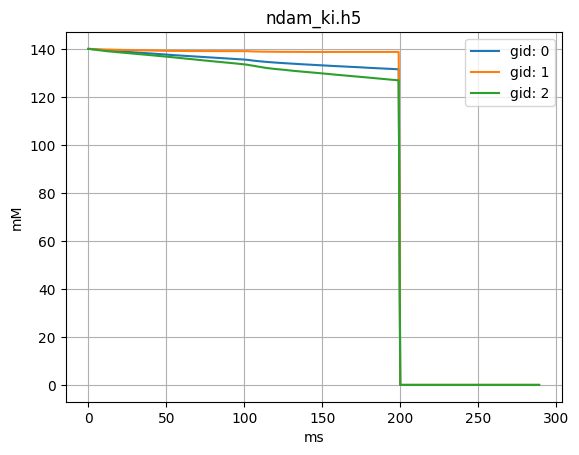

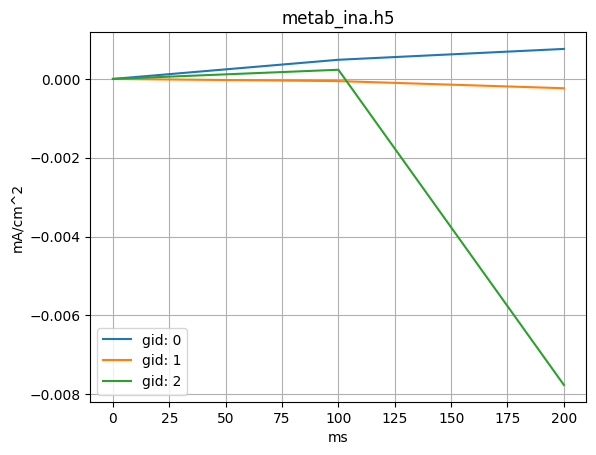

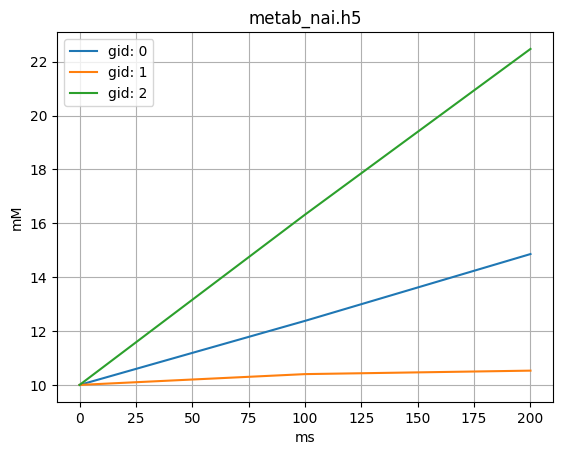

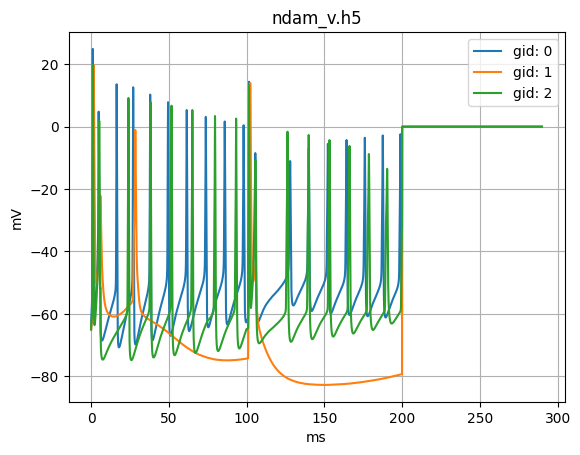

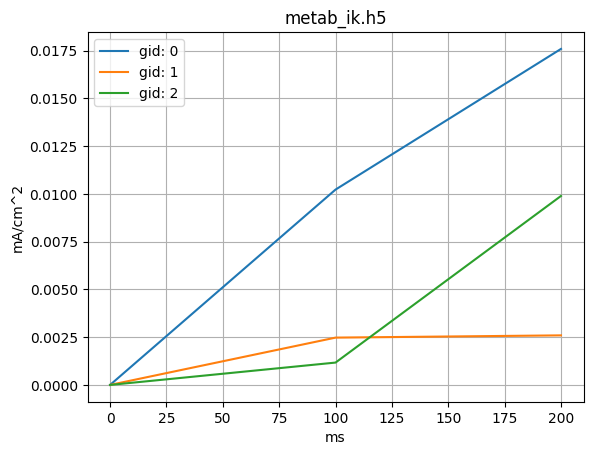

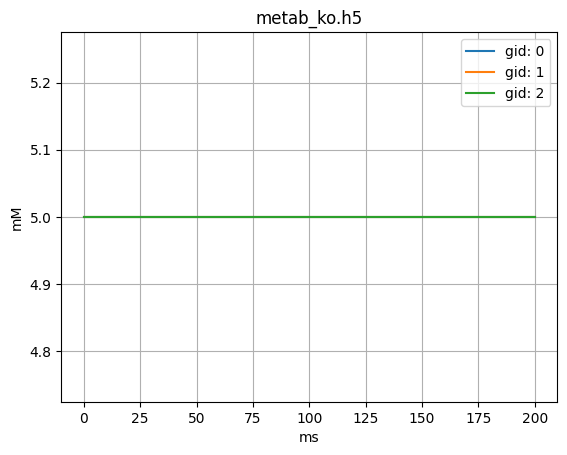

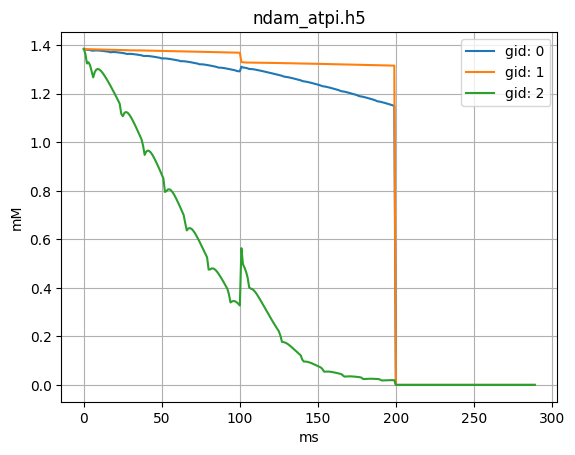

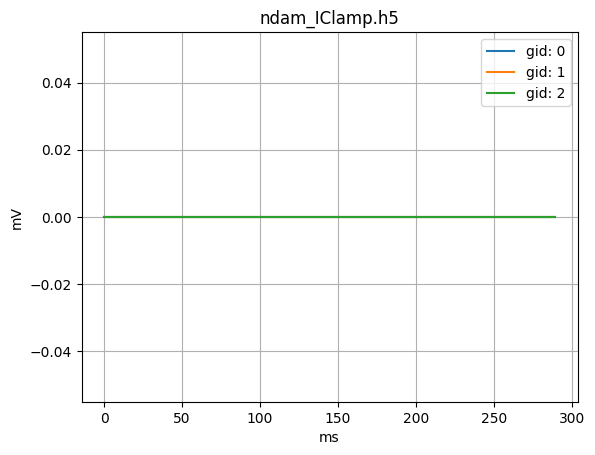

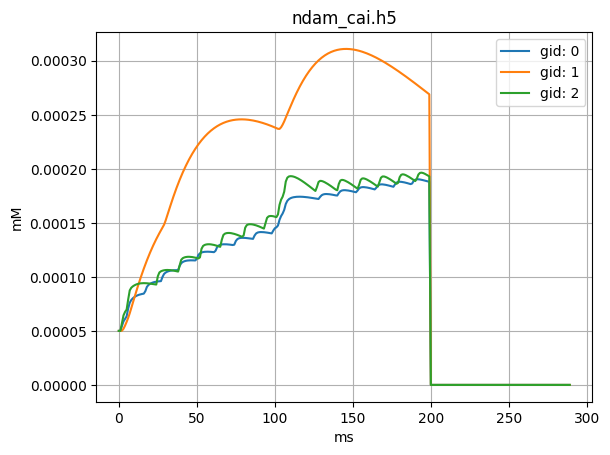

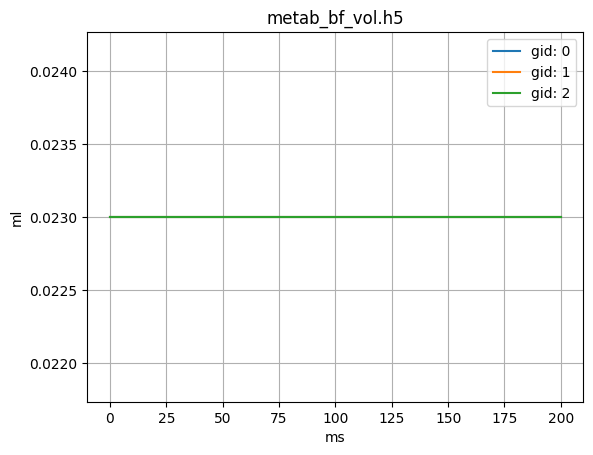

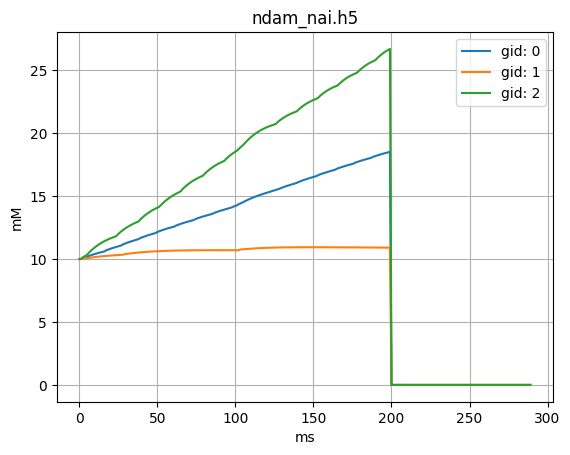

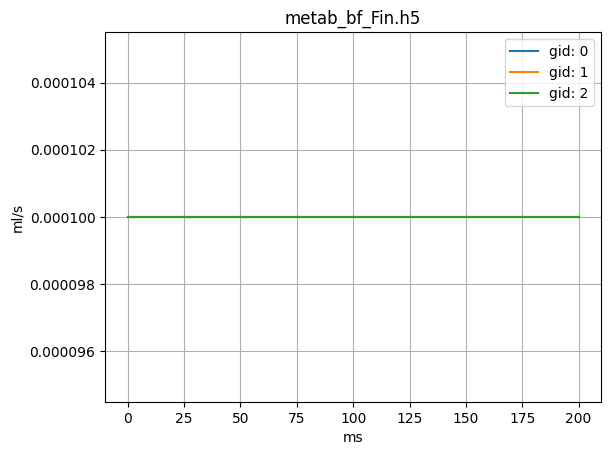

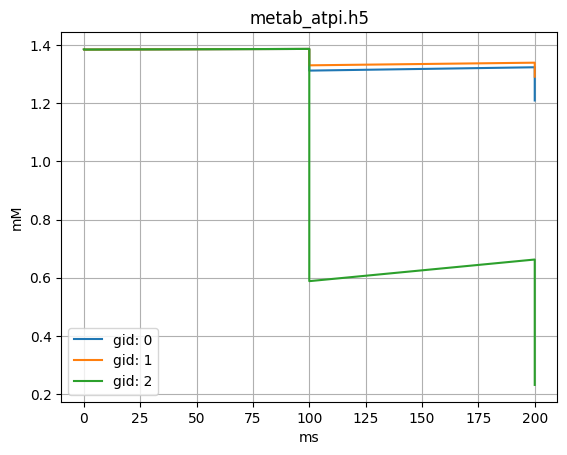

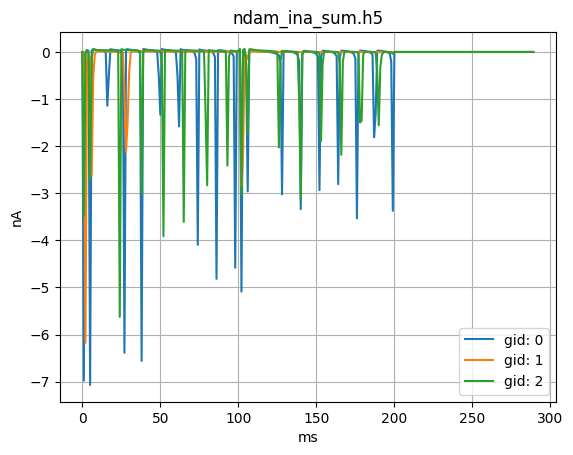

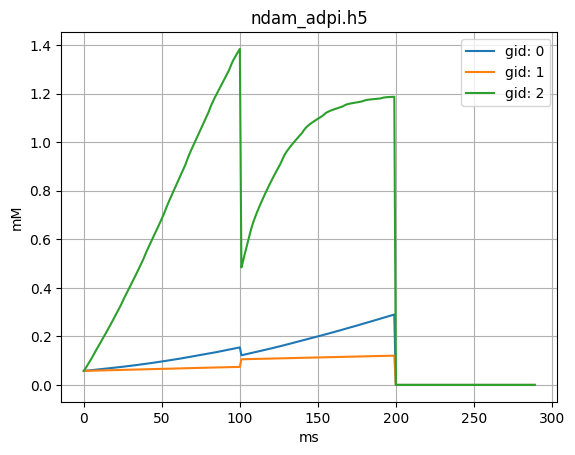

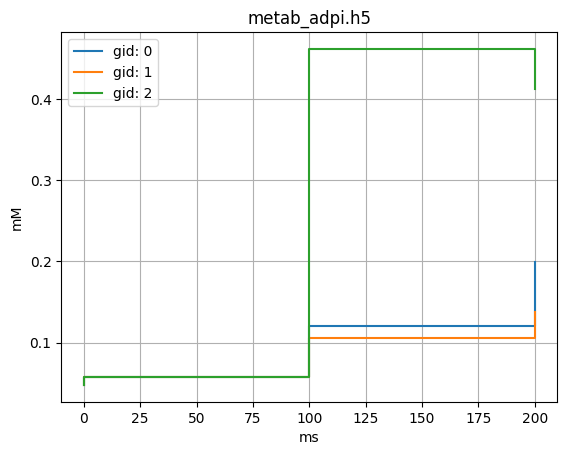

In [5]:
# Get user input for GiD and Quantity
selected_gids = [0, 1, 2]
selected_quantities = [
    i for i in all_quantities[0] if i.startswith("metab") or i.startswith("ndam")
]
# selected_quantities = ["metab_ko.h5"]
img_path = paths[0] / "img"
filter_name = "alive_gids.h5"


def filter(v, fil):
    return [i for idx, i in enumerate(v) if fil[idx]]


img_path.mkdir(parents=True, exist_ok=True)
for quantity in selected_quantities:
    if "after" in quantity:
        continue
    print(f"processing: {quantity}")
    plt.figure()
    for uu in units:
        try:
            u = uu[quantity]
        except KeyError:
            continue

    plt.xlabel(u[0])
    plt.ylabel(u[1])
    if "before" in quantity:
        plt.title(f"{quantity[:-15]}.h5")
    else:
        plt.title(f"{quantity}")
    # Loop through selected gids (traces) for the current quantity
    for ii, path in enumerate(paths):
        for gid in selected_gids:
            try:
                trace_data = dfs[ii][quantity][gid]
                time_data = dfs[ii][quantity]["t"]
                if filter_name and "metab" in quantity:
                    # Get the time trace data for the current quantity and gid
                    trace_data = filter(v=dfs[ii][quantity][gid], fil=dfs[ii][filter_name][gid])
                    time_data = filter(v=dfs[ii][quantity]["t"], fil=dfs[ii][filter_name][gid])
                    if "before" in quantity:
                        after_quantity = quantity.replace("before", "after")
                        after_trace_data = filter(
                            v=dfs[ii][after_quantity][gid],
                            fil=dfs[ii][filter_name][gid],
                        )
                        trace_data = [
                            item for pair in zip(trace_data, after_trace_data) for item in pair
                        ]
                        time_data = [item for pair in zip(time_data, time_data) for item in pair]
            except KeyError:
                continue

            # Plot the time trace
            plt.plot(time_data, trace_data, label=f"gid: {gid}")

    # Customize the plot
    plt.legend()
    plt.grid(True)

    # Save the figure
    save_path = img_path / f"{quantity[:-3]}.jpg"
    plt.savefig(save_path, format="jpg")

# Show all the plots
plt.show()